Normal Gravity with Competing Sweet Spots


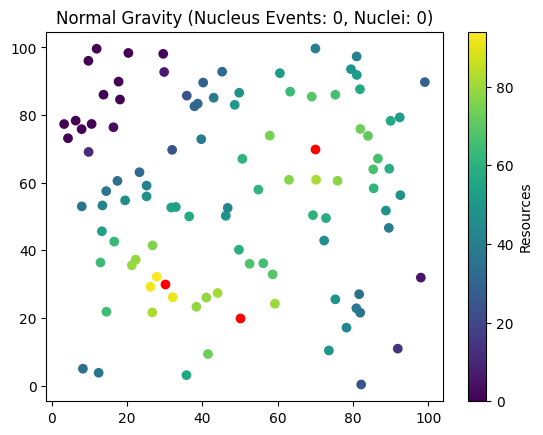

Nucleus Events: 0, Nucleus Count: 0, Avg Resources: 46.17, Avg Mass: 1.26, Population: 100, Positive Tropism Ratio: 0.46, Avg Tropism Strength: 0.50

Microgravity


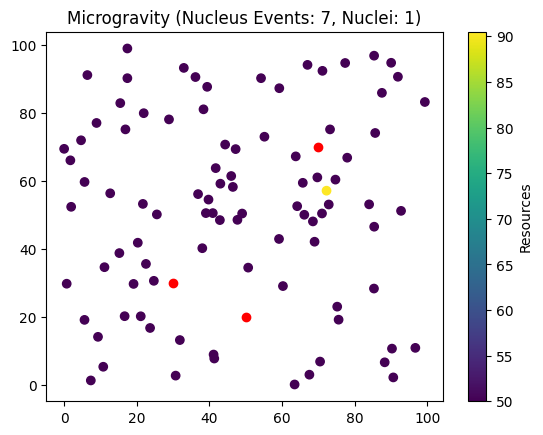

Nucleus Events: 7, Nucleus Count: 1, Avg Resources: 50.44, Avg Mass: 1.28, Population: 93, Positive Tropism Ratio: 0.57, Avg Tropism Strength: 0.50


In [3]:
import numpy as np
from mesa import Model
from mesa.space import ContinuousSpace
import matplotlib.pyplot as plt
import random

# Gravitational centers (position, strength) for sweet spots
GRAVITY_CENTERS = [
    (np.array([30, 30]), 1.0),  # Strongest
    (np.array([70, 70]), 0.7),  # Medium
    (np.array([50, 20]), 0.5)   # Weakest
]
G_NORMAL = 0.1  # Scaled gravitational constant
G_MICRO = 0     # Microgravity

class Tropism:
    def __init__(self, type="positive", strength=0.5, threshold=0.1):
        self.type = type          # "positive" or "negative"
        self.strength = strength  # [0, 1]: Influence of gravity
        self.threshold = threshold  # Minimum force to trigger

    def mutate(self):
        self.strength = max(0, min(1, self.strength + np.random.uniform(-0.1, 0.1)))
        self.threshold = max(0, min(1, self.threshold + np.random.uniform(-0.05, 0.05)))

class BuildingBlock:
    def __init__(self, unique_id, model, mass=1.0):
        self.unique_id = unique_id
        self.model = model
        self.mass = mass  # Influences aggregation
        self.resources = 0  # Energy/materials collected
        self.tropism = Tropism(type=random.choice(["positive", "negative"]), strength=0.5, threshold=0.1)
        self.pos = np.array([np.random.uniform(0, 99.999), np.random.uniform(0, 99.999)])
        self.has_nucleus = False  # Tracks nucleus formation
        self.components = []  # Attached units (e.g., membrane, processors)

    def step(self):
        # Movement with tropism
        if self.model.G != G_MICRO:
            nearest_pos, grav_strength = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0]))
            r = np.linalg.norm(self.pos - nearest_pos)
            if r > 0:
                force = self.model.G * grav_strength / (r**2) / self.mass  # Mass affects movement
                if force > self.tropism.threshold:
                    direction = (nearest_pos - self.pos) / r if self.tropism.type == "positive" else (self.pos - nearest_pos) / r
                    self.pos += direction * force * self.tropism.strength * 0.1
        else:
            self.pos += np.random.uniform(-1.0, 1.0, 2) * 0.1 / self.mass

        self.pos = np.clip(self.pos, 0, 99.999)

        # Resource consumption
        nearest_pos, _ = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0]))
        r = np.linalg.norm(self.pos - nearest_pos)
        resource_density = max(0, 10 - r / 5) if self.model.G != G_MICRO else 5
        self.resources += resource_density * 0.1  # Gradual accumulation

        # Aggregation and nucleus formation (custom neighbor detection)
        for other in self.model.blocks[:]:
            if other.unique_id != self.unique_id and not self.has_nucleus:
                distance = np.linalg.norm(self.pos - other.pos)
                if distance < 1.0 and self.resources > 20:
                    self.mass += other.mass
                    self.resources += other.resources
                    self.has_nucleus = True  # Nucleus forms
                    self.components.append("membrane")
                    self.model.blocks.remove(other)
                    self.model.nucleus_events += 1
                    break

        # Growth: Add components if nucleus exists
        if self.has_nucleus and self.resources > 30 and random.random() < 0.05:
            self.components.append("processor")
            self.resources -= 10

class AssemblyModel(Model):
    def __init__(self, N_blocks, G):
        super().__init__()
        self.G = G
        self.space = ContinuousSpace(100, 100, torus=False)  # Used for visualization
        self.blocks = []  # Corrected from 'keys' to ensure consistency
        self.nucleus_events = 0

        # Initialize building blocks
        for i in range(N_blocks):
            block = BuildingBlock(i, self, mass=np.random.uniform(0.5, 2.0))
            self.blocks.append(block)

    def step(self):
        # Step all blocks
        for block in self.blocks[:]:  # Copy list to avoid modification issues
            block.step()

def run_simulation(gravity, label, steps=100):
    model = AssemblyModel(100, gravity)
    for _ in range(steps):
        model.step()

    blocks = model.blocks
    positions = [b.pos for b in blocks]
    x, y = zip(*positions)
    resources = [b.resources for b in blocks]
    nucleus_count = sum(1 for b in blocks if b.has_nucleus)
    avg_mass = np.mean([b.mass for b in blocks])
    tropism_types = [b.tropism.type for b in blocks]
    avg_tropism_strength = np.mean([b.tropism.strength for b in blocks])

    # Plot
    plt.scatter(x, y, c=resources, cmap="viridis")
    plt.colorbar(label="Resources")
    for pos, _ in GRAVITY_CENTERS:
        plt.plot(pos[0], pos[1], 'ro')
    plt.title(f"{label} (Nucleus Events: {model.nucleus_events}, Nuclei: {nucleus_count})")
    plt.show()

    return {
        "nucleus_events": model.nucleus_events,
        "nucleus_count": nucleus_count,
        "avg_resources": np.mean(resources),
        "avg_mass": avg_mass,
        "population": len(blocks),
        "positive_tropism_ratio": tropism_types.count("positive") / len(tropism_types) if tropism_types else 0,
        "avg_tropism_strength": avg_tropism_strength
    }

# Run simulations
print("Normal Gravity with Competing Sweet Spots")
normal_results = run_simulation(G_NORMAL, "Normal Gravity")
print(f"Nucleus Events: {normal_results['nucleus_events']}, "
      f"Nucleus Count: {normal_results['nucleus_count']}, "
      f"Avg Resources: {normal_results['avg_resources']:.2f}, "
      f"Avg Mass: {normal_results['avg_mass']:.2f}, "
      f"Population: {normal_results['population']}, "
      f"Positive Tropism Ratio: {normal_results['positive_tropism_ratio']:.2f}, "
      f"Avg Tropism Strength: {normal_results['avg_tropism_strength']:.2f}")

print("\nMicrogravity")
micro_results = run_simulation(G_MICRO, "Microgravity")
print(f"Nucleus Events: {micro_results['nucleus_events']}, "
      f"Nucleus Count: {micro_results['nucleus_count']}, "
      f"Avg Resources: {micro_results['avg_resources']:.2f}, "
      f"Avg Mass: {micro_results['avg_mass']:.2f}, "
      f"Population: {micro_results['population']}, "
      f"Positive Tropism Ratio: {micro_results['positive_tropism_ratio']:.2f}, "
      f"Avg Tropism Strength: {micro_results['avg_tropism_strength']:.2f}")